# Homework 10 - Network Compression

Author: Liang-Hsuan Tseng (b07502072@ntu.edu.tw), modified from ML2021-HW13

If you have any questions, feel free to ask: ntu-ml-2022spring-ta@googlegroups.com

[**Link to HW10 Slides**](https://docs.google.com/presentation/d/1nCT9XrInF21B4qQAWuODy5sonKDnpGhjtcAwqa75mVU/edit#slide=id.p)

## Outline

* [Packages](#Packages) - intall some required packages.
* [Dataset](#Dataset) - something you need to know about the dataset.
* [Configs](#Configs) - the configs of the experiments, you can change some hyperparameters here.
* [Architecture_Design](#Architecture_Design) - depthwise and pointwise convolution examples and some useful links.
* [Knowledge_Distillation](#Knowledge_Distillation) - KL divergence loss for knowledge distillation and some useful links.
* [Training](#Training) - training loop implementation modified from HW3.
* [Inference](#Inference) - create submission.csv by using the student_best.ckpt from the previous experiment.



### Packages
First, we need to import some useful packages. If the torchsummary package are not intalled, please install it via `pip install torchsummary`

In [1]:
# !pip install pandas
# !pip install torchsummary

In [2]:
# Import some useful packages for this homework
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset # "ConcatDataset" and "Subset" are possibly useful
from torchvision.datasets import DatasetFolder, VisionDataset
from torchsummary import summary
from tqdm.auto import tqdm
import random
import inspect

# !nvidia-smi # list your current GPU

### Configs
In this part, you can specify some variables and hyperparameters as your configs.

In [3]:
from main import cfg
print(cfg)

from utils import seed
lines = inspect.getsource(seed)
print(lines)

{'dataset_root': './food11-hw13', 'save_dir': './outputs', 'exp_name': 'simple_baseline', 'batch_size': 64, 'lr': 0.0002, 'seed': 20220013, 'loss_fn_type': 'KD', 'weight_decay': 2e-05, 'grad_norm_max': 10, 'n_epochs': 500, 'patience': 100}
def seed(myseed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(myseed)
    torch.manual_seed(myseed)
    random.seed(myseed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(myseed)



In [4]:
myseed = cfg['seed']  # set a random seed for reproducibility

save_path = os.path.join(cfg['save_dir'], cfg['exp_name']) # create saving directory
os.makedirs(save_path, exist_ok=True)

# define simple logging functionality
log_fw = open(f"{save_path}/log.txt", 'w') # open log file to save log outputs
def log(text):     # define a logging function to trace the training process
    print(text)
    log_fw.write(str(text)+'\n')
    log_fw.flush()

log(cfg)  # log your configs to the log file

{'dataset_root': './food11-hw13', 'save_dir': './outputs', 'exp_name': 'simple_baseline', 'batch_size': 64, 'lr': 0.0002, 'seed': 20220013, 'loss_fn_type': 'KD', 'weight_decay': 2e-05, 'grad_norm_max': 10, 'n_epochs': 500, 'patience': 100}


### Dataset
We use Food11 dataset for this homework, which is similar to homework3. But remember, Please DO NOT utilize the dataset of HW3. We've modified the dataset, so you should only access the dataset by loading it in this kaggle notebook or through the links provided in the HW13 colab notebooks.

In [5]:
# fetch and download the dataset from github (about 1.12G)
# !wget https://github.com/virginiakm1988/ML2022-Spring/raw/main/HW13/food11-hw13.tar.gz 
## backup links:

# !wget https://github.com/andybi7676/ml2022spring-hw13/raw/main/food11-hw13.tar.gz -O food11-hw13.tar.gz
# !gdown '1ijKoNmpike_yjUw8SWRVVWVoMOXXqycj' --output food11-hw13.tar.gz

In [6]:
# extract the data
# !tar -xzf ./food11-hw13.tar.gz # Could take some time
# !tar -xzvf ./food11-hw13.tar.gz # use this command if you want to checkout the whole process.

In [ ]:
for dirname, _, filenames in os.walk('./food11-hw13'):
    if len(filenames) > 0:
        print(f"{dirname}: {len(filenames)} files.") # Show the file amounts in each split.

./food11-hw13: 1 files.
./food11-hw13/validation: 3430 files.
./food11-hw13/evaluation: 3347 files.
./food11-hw13/training: 9866 files.


Next, specify train/test transform for image data augmentation.
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms. You can also apply the knowledge or experience you learned in HW3.

In [8]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# # define training/testing transforms
# test_tfm = transforms.Compose([
#     # It is not encouraged to modify this part if you are using the provided teacher model. This transform is stardard and good enough for testing.
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     normalize,
# ])

# train_tfm = transforms.Compose([
#     # add some useful transform or augmentation here, according to your experience in HW3.
#     transforms.Resize(256),  # You can change this
#     transforms.CenterCrop(224), # You can change this, but be aware of that the given teacher model's input size is 224.
#     # The training input size of the provided teacher model is (3, 224, 224).
#     # Thus, Input size other then 224 might hurt the performance. please be careful.
#     transforms.RandomHorizontalFlip(), # You can change this.
#     transforms.ToTensor(),
#     normalize,
# ])

from dataset import normalize, test_tfm, train_tfm
print(normalize)
print(test_tfm)
print(train_tfm)

Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.5, 0.9), contrast=None, saturation=None, hue=None)
    ColorJitter(brightness=None, contrast=(0.5, 0.9), saturation=None, hue=None)
    ColorJitter(brightness=None, contrast=None, saturation=(0.5, 0.9), hue=None)
    ColorJitter(brightness=None, contrast=None, saturation=None, hue=(-0.2, 0.2))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [9]:
from dataset import FoodDataset
lines = inspect.getsource(FoodDataset)
print(lines)    

class FoodDataset(Dataset):
    def __init__(self, path, tfm=test_tfm, files = None):
        super().__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("/")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label



In [10]:
from dataset import get_dataset
lines = inspect.getsource(get_dataset)
print(lines) 

train_loader, valid_loader = get_dataset(cfg)

def get_dataset(cfg):        
    # Form train/valid dataloaders
    train_set = FoodDataset(os.path.join(cfg['dataset_root'],"training"), tfm=train_tfm)
    train_loader = DataLoader(train_set, batch_size=cfg['batch_size'], shuffle=True, num_workers=0, pin_memory=True)

    valid_set = FoodDataset(os.path.join(cfg['dataset_root'], "validation"), tfm=test_tfm)
    valid_loader = DataLoader(valid_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

    return train_loader, valid_loader

One ./food11-hw13/training sample ./food11-hw13/training/0_0.jpg
One ./food11-hw13/validation sample ./food11-hw13/validation/0_0.jpg


### Architecture_Design

In this homework, you have to design a smaller network and make it perform well. Apparently, a well-designed architecture is crucial for such task. Here, we introduce the depthwise and pointwise convolution. These variants of convolution are some common techniques for architecture design when it comes to network compression.

<img src="https://i.imgur.com/LFDKHOp.png" width=400px>

* explanation of depthwise and pointwise convolutions:
    * [prof. Hung-yi Lee's slides(p.24~p.30, especially p.28)](https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/tiny_v7.pdf)

## **Depthwise & Pointwise Convolution**
![](https://i.imgur.com/FBgcA0s.png)
> Blue: the connection between layers \
> Green: the expansion of **receptive field** \
> (reference: arxiv:1810.04231)
(a) normal convolution layer: It is fully connected. The difference between fully connected layer and fully connected convolution layer is the operation. (multiply --> convolution)
(b) Depthwise convolution layer(DW): You can consider each feature map pass through their own filter and then pass through pointwise convolution layer(PW) to combine the information of all pixels in feature maps.
(c) Group convolution layer(GC): Group the feature maps. Each group passes their filter then concate together. If group_size = input_feature_size, then GC becomes DC (channels are independent). If group_size = 1, then GC becomes fully connected.
<img src="https://i.imgur.com/Hqhg0Q9.png" width="500px">

## **Implementation details**
```python
# Regular Convolution, # of params = in_chs * out_chs * kernel_size^2
nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding)
# Group Convolution, "groups" controls the connections between inputs and
# outputs. in_chs and out_chs must both be divisible by groups.
nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding, groups=groups)
# Depthwise Convolution, out_chs=in_chs=groups, # of params = in_chs * kernel_size^2
nn.Conv2d(in_chs, out_chs=in_chs, kernel_size, stride, padding, groups=in_chs)
# Pointwise Convolution, a.k.a 1 by 1 convolution, # of params = in_chs * out_chs
nn.Conv2d(in_chs, out_chs, 1)
# Merge Depthwise and Pointwise Convolution (without )
def dwpw_conv(in_chs, out_chs, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_chs, in_chs, kernels, stride, padding, groups=in_chs),
        nn.Conv2d(in_chs, out_chs, 1),
    )
```

* other useful techniques
    * [group convolution](https://www.researchgate.net/figure/The-transformations-within-a-layer-in-DenseNets-left-and-CondenseNets-at-training-time_fig2_321325862) (Actually, depthwise convolution is a specific type of group convolution)
    * [SqueezeNet](!https://arxiv.org/abs/1602.07360)
    * [MobileNet](!https://arxiv.org/abs/1704.04861)
    * [ShuffleNet](!https://arxiv.org/abs/1707.01083)
    * [Xception](!https://arxiv.org/abs/1610.02357)
    * [GhostNet](!https://arxiv.org/abs/1911.11907)


After introducing depthwise and pointwise convolutions, let's define the **student network architecture**. Here, we have a very simple network formed by some regular convolution layers and pooling layers. You can replace the regular convolution layers with the depthwise and pointwise convolutions. In this way, you can further increase the depth or the width of your network architecture.

In [11]:
# Define your student network here. You have to copy-paste this code block to HW13 GradeScope before deadline.
# We will use your student network definition to evaluate your results(including the total parameter amount).

# baseline / Medium
class StudentNet(nn.Module):
    def __init__(self):
        super().__init__()

        # ---------- TODO ----------
        # Modify your model architecture

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 3), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),    
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),         

            nn.Conv2d(32, 64, 3), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),         

            nn.Conv2d(64, 100, 3), 
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            # Here we adopt Global Average Pooling for various input size.
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Sequential(
            nn.Linear(100, 11),
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
    
# Strong
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()

        # ---------- TODO ----------
        # Modify your model architecture

        self.cnn = nn.Sequential(
          nn.Conv2d(3, 3, 3, stride = 1, padding = 1, groups = 3), 
          nn.Conv2d(3, 64, 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),

          nn.Conv2d(64, 64, 3, stride = 1, padding = 1, groups = 64), 
          nn.Conv2d(64, 64, 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2, 2, 0),

          nn.Conv2d(64, 64, 3, stride = 1, padding = 1, groups = 64), 
          nn.Conv2d(64, 64, 1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(2, 2, 0), 

          nn.Conv2d(64, 64, 3, stride = 1, padding = 1, groups = 64), 
          nn.Conv2d(64, 128, 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(2, 2, 0), 

          nn.Conv2d(128, 128, 3, stride = 1, padding = 1, groups = 128), 
          nn.Conv2d(128, 128, 1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.MaxPool2d(2, 2, 0), 

          nn.Conv2d(128, 128, 3, stride = 1, padding = 1, groups = 128), 
          nn.Conv2d(128, 256, 1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.MaxPool2d(2, 2, 0),

              

          # Here we adopt Global Average Pooling for various input size.
          nn.AdaptiveAvgPool2d((1, 1)),
          
      )
        self.fc = nn.Sequential(
          nn.Linear(256, 11),
        )
      
    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        # print(out.size())
        return self.fc(out)
    
class StudentDWPW_Net(nn.Module):
    def __init__(self):
        super().__init__()

        # ---------- TODO ----------
        # Modify your model architecture

        self.cnn = nn.Sequential(
            dwpw_conv(3, 32, 3), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            dwpw_conv(32, 32, 3),    
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),         

            dwpw_conv(32, 64, 3), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),         

            dwpw_conv(64, 100, 3), 
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            # Here we adopt Global Average Pooling for various input size.
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Sequential(
            nn.Linear(100, 11),
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)    

def get_student_model(): # This function should have no arguments so that we can get your student network by directly calling it.
    # you can modify or do anything here, just remember to return an nn.Module as your student network.    
    return StudentNet() 
    # return StudentDWPW_Net() 

# End of definition of your student model and the get_student_model API
# Please copy-paste the whole code block, including the get_student_model function.

After specifying the student network architecture, please use `torchsummary` package to get information about the network and verify the total number of parameters. Note that the total params of your student network should not exceed the limit (`Total params` in `torchsummary` ≤ 100,000). 

In [12]:
# DO NOT modify this block and please make sure that this block can run sucessfully. 
student_model = get_student_model()
summary(student_model, (3, 224, 224), device='cpu')
# You have to copy&paste the results of this block to HW13 GradeScope. 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]              30
            Conv2d-2         [-1, 64, 224, 224]             256
       BatchNorm2d-3         [-1, 64, 224, 224]             128
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]             640
            Conv2d-6         [-1, 64, 224, 224]           4,160
       BatchNorm2d-7         [-1, 64, 224, 224]             128
              ReLU-8         [-1, 64, 224, 224]               0
         MaxPool2d-9         [-1, 64, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]             640
           Conv2d-11         [-1, 64, 112, 112]           4,160
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [13]:
# Load provided teacher model (model architecture: resnet18, num_classes=11, test-acc ~= 89.9%)
teacher_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=11)
# load state dict
teacher_ckpt_path = os.path.join(cfg['dataset_root'], "resnet18_teacher.ckpt")
teacher_model.load_state_dict(torch.load(teacher_ckpt_path, map_location='cpu'))
# Now you already know the teacher model's architecture. You can take advantage of it if you want to pass the strong or boss baseline. 
# Source code of resnet in pytorch: (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
# You can also see the summary of teacher model. There are 11,182,155 parameters totally in the teacher model
# summary(teacher_model, (3, 224, 224), device='cpu')

Using cache found in /home/leyan/.cache/torch/hub/pytorch_vision_v0.10.0
/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

### Knowledge_Distillation

<img src="https://i.imgur.com/H2aF7Rv.png=100x" width="400px">

Since we have a learned big model, let it teach the other small model. In implementation, let the training target be the prediction of big model instead of the ground truth.

**Why it works?**
* If the data is not clean, then the prediction of big model could ignore the noise of the data with wrong labeled.
* There might have some relations between classes, so soft labels from teacher model might be useful. For example, Number 8 is more similar to 6, 9, 0 than 1, 7.


**How to implement?**
* $Loss = \alpha T^2 \times KL(p || q) + (1-\alpha)(\text{Original Cross Entropy Loss}), \text{where } p=softmax(\frac{\text{student's logits}}{T}), \text{and } q=softmax(\frac{\text{teacher's logits}}{T})$
* very useful link: [pytorch docs of KLDivLoss with examples](!https://pytorch.org/docs/stable/generated/torch.nn.KLDivLoss.html)
* original paper: [Distilling the Knowledge in a Neural Network](!https://arxiv.org/abs/1503.02531)

In [14]:
# Implement the loss function with KL divergence loss for knowledge distillation.
# You also have to copy-paste this whole block to HW13 GradeScope. 
def loss_fn_kd(student_logits, labels, teacher_logits, alpha=0.5, temperature=32):
    # ------------TODO-------------
    # Refer to the above formula and finish the loss function for knowkedge distillation using KL divergence loss and CE loss.
    # If you have no idea, please take a look at the provided useful link above.
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    ce_loss = nn.CrossEntropyLoss()
    
    return alpha * pow(temperature, 2) * kl_loss(F.log_softmax(student_logits/temperature, dim=1), \
                                                 F.softmax(teacher_logits/temperature, dim=1)) + \
                                        (1-alpha)*ce_loss(student_logits, labels)
    # pass
    
# You can also adopt other types of knowledge distillation techniques for strong and boss baseline, but use function name other than `loss_fn_kd`
# For example:
def loss_fn_custom_kd():
    pass    

In [15]:
# choose the loss function by the config
if cfg['loss_fn_type'] == 'CE':
    # For the classification task, we use cross-entropy as the default loss function.
    loss_fn = nn.CrossEntropyLoss() # loss function for simple baseline.

if cfg['loss_fn_type'] == 'KD': # KD stands for knowledge distillation
    loss_fn = loss_fn_kd # implement loss_fn_kd for the report question and the medium baseline.

if cfg['loss_fn_type'] == 'custom_kd':
    loss_fn = loss_fn_custom_kd

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
log(f"device: {device}")

# The number of training epochs and patience.
n_epochs = cfg['n_epochs']
patience = cfg['patience'] # If no improvement in 'patience' epochs, early stop

device: cuda


### Training
implement training loop for simple baseline, feel free to modify it.

In [ ]:
# Initialize a model, and put it on the device specified.
student_model.to(device)
teacher_model.to(device) # MEDIUM BASELINE

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(student_model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay']) 

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0.0

teacher_model.eval()  # MEDIUM BASELINE
for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    student_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    train_lens = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        with torch.no_grad():  # MEDIUM BASELINE
            teacher_logits = teacher_model(imgs)  # MEDIUM BASELINE
        
        logits = student_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = loss_fn(logits, labels, teacher_logits) # MEDIUM BASELINE
        # loss = loss_fn(logits, labels) # SIMPLE BASELINE
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=cfg['grad_norm_max'])

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        train_batch_len = len(imgs)
        train_loss.append(loss.item() * train_batch_len)
        train_accs.append(acc)
        train_lens.append(train_batch_len)
        
    train_loss = sum(train_loss) / sum(train_lens)
    train_acc = sum(train_accs) / sum(train_lens)

    # Print the information.
    log(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    student_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    valid_lens = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = student_model(imgs)
            teacher_logits = teacher_model(imgs) # MEDIUM BASELINE

        # We can still compute the loss (but not the gradient).
        loss = loss_fn(logits, labels, teacher_logits) # MEDIUM BASELINE
        # loss = loss_fn(logits, labels) # SIMPLE BASELINE

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        batch_len = len(imgs)
        valid_loss.append(loss.item() * batch_len)
        valid_accs.append(acc)
        valid_lens.append(batch_len)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / sum(valid_lens)
    valid_acc = sum(valid_accs) / sum(valid_lens)

    # update logs
    
    if valid_acc > best_acc:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        log(f"Best model found at epoch {epoch}, saving model")
        torch.save(student_model.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            log(f"No improvment {patience} consecutive epochs, early stopping")
            break
log("Finish training")
log_fw.close()

### baseline
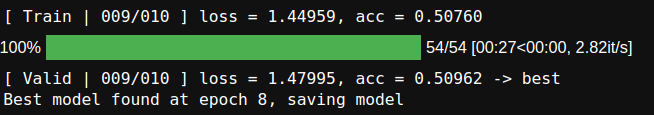

### Medium
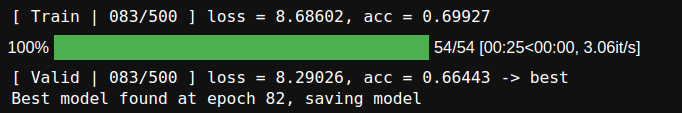